## Assignment #2

* Release date: 2023.10.11 Wed
* Due date: **2023.10.18 Wed 23:59** (will not accept late submission)
* Submission format: notebook file which can be executed in Colab environment
* Weighting: 5% (total 50 pts)
* You will build a multi-class classification model using Reuters dataset.

> ### Loading and preprocessing data

In [126]:
from tensorflow.keras.datasets import reuters

# Like IMDB, the argument num_words restricts the data to
# the 10,000 most frequently occurring words
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

* (10pts) Write the codes for preprocessing data
  * For inputs, the data we have should be converted to binary vectors.
  * For labels, determine an appropriate format by referring to the arguments of model.compile function below.

In [127]:
# write preprocessing codes

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

> ### Building the network

In [128]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [129]:
# Do not modify this block
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### Validation

* We employ *k-fold cross validation* as validation method of our model.
* **(15pts)** Write a code in the below to perform *10-fold cross validation*.
* **For each fold, save a model at every epoch in your Google Drive.**

In [130]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
# write a code for 10-fold cross validation here
from keras import callbacks
import numpy as np

k = 10
num_val_samples = len(x_train) // k
num_epochs = 20

acc_matrix = []
val_acc_matrix = []

for i in range(k):
  print('processing fold #', i+1)
  filepath = '/content/drive/My Drive/AI/assignment2/model.fold'+str(i)+'.{epoch:02d}.hdf5'
  callback = callbacks.ModelCheckpoint(filepath)


  # build model
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(46, activation='softmax'))
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


  val_data = x_train[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = y_train[i*num_val_samples: (i+1)*num_val_samples]

  partial_train_data = np.concatenate([x_train[:i*num_val_samples], x_train[(i+1)*num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate([y_train[:i*num_val_samples], y_train[(i+1)*num_val_samples:]], axis=0)

  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), callbacks = [callback], epochs=num_epochs,batch_size=128,  verbose=0)


  #save accuracy
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  acc_matrix.append(acc)
  val_acc_matrix.append(val_acc)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9
processing fold # 10


* **(10pts)** Plotting the training and validation accuracy
  * To obtain the validation accuracy at the end of every epoch, just average the performances of all folds.

In [132]:
average_acc_history = [np.mean([x[i] for x in acc_matrix]) for i in range(num_epochs)]
average_val_history = [np.mean([x[i] for x in val_acc_matrix]) for i in range(num_epochs)]

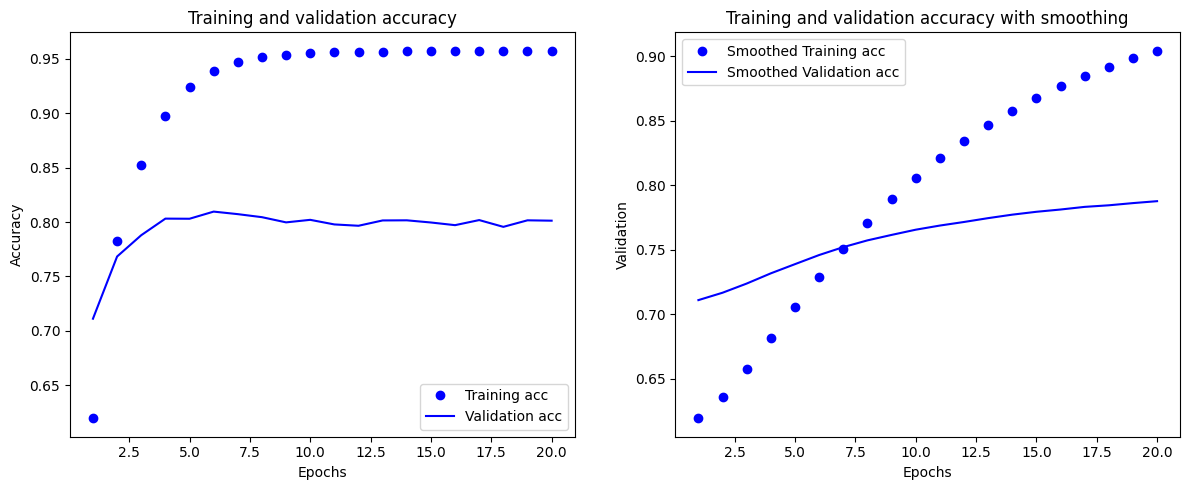

In [133]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(average_val_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the training and validation accuracy on the first subplot
axs[0].plot(epochs, average_acc_history, 'bo', label='Training acc')
axs[0].plot(epochs, average_val_history, 'b', label='Validation acc')
axs[0].set_title('Training and validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()



def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

average_acc_history = smooth_curve(average_acc_history)
average_val_history = smooth_curve(average_val_history)

# Plot the training and validation accuracy with smoothing on the second subplot
axs[1].plot(epochs, average_acc_history, 'bo', label='Smoothed Training acc')
axs[1].plot(epochs, average_val_history,'b',label='Smoothed Validation acc')
axs[1].set_title('Training and validation accuracy with smoothing')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Validation')
axs[1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.2) # Adjust space between subplots
plt.show()

> ### Inference

* Find the best performance model (i.e., the best epoch showing the highest validation accuracy averaged over folds) by seeing the performance plot.
* **(10pts)** Calculate the accuracy on test set using the 10 models at the best epoch.
  * Here, you should use a majority voting method to get the prediction for a test data point.
  * Specifically, given a test data point, get the predicted class from the trained model on each fold, and then decide the final predicted class by a majority voting.
* **Do not retrain the model.**

###Find the best performance model:

When looking at the 'Training and validation accuracy with smoothing' graph, we can see an intersection of training and validation accuracy curves approximately at epoch 7. This indicates that the model trained for 7 epochs could be considered an ideal model because it exhibits comparable accuracies for both training and validation phases at this stage.

In [134]:
# Set best model from epoch 7
pred_matrix = []
test_len = len(test_labels)
for i in range(10):
  best_model_path = '/content/drive/My Drive/AI/assignment2/model.fold'+str(i)+'.07.hdf5'
  best_model = models.load_model(best_model_path)

  predictions = best_model.predict(x_test)
  predictions = np.rint(predictions)
  pred_matrix.append(np.argmax(predictions,axis =1))

71/71 [==============================] - 0s 2ms/step


In [135]:
def majority_voting(pred_matrix):
  length = len(pred_matrix[0])
  reshape_predict = np.array(pred_matrix)
  reshape_predict = reshape_predict.reshape((length*10),order='F')
  reshape_predict = reshape_predict.reshape((length,10))
  vote_res = []

  from collections import Counter

  for i in range(length):
    vote_res.append( Counter(reshape_predict[i]).most_common(1)[0][0] )

  return vote_res


result = majority_voting(pred_matrix)

from sklearn.metrics import accuracy_score
best_model_acc = accuracy_score(result,test_labels)
print(best_model_acc)

0.7622439893143366


* **(5pts)** Compare the accuracy above with the performance from a single model at the best epoch from any fold, and discuss the difference between those accuracies.

In [136]:
# find single best fold model at the best epoch
best_fold=0
best_acc=0
for i in range(10):
  best_model_path = '/content/drive/My Drive/AI/assignment2/model.fold'+str(i)+'.07.hdf5'
  best_model = models.load_model(best_model_path)

  predictions = best_model.predict(x_test)
  predictions = np.rint(predictions)
  result = np.argmax(predictions,axis =1)

  fold_acc = accuracy_score(result,test_labels)
  print('acc for fold %d: '%(i), fold_acc)

  if fold_acc > best_acc:
    best_fold=i
    best_acc=fold_acc

print('best_fold: ',best_fold)
print('best_acc: ',best_acc)

71/71 [==============================] - 0s 2ms/step
acc for fold 0:  0.7484416740872663
71/71 [==============================] - 0s 2ms/step
acc for fold 1:  0.7462154942119323
71/71 [==============================] - 0s 2ms/step
acc for fold 2:  0.7586821015138023
71/71 [==============================] - 0s 2ms/step
acc for fold 3:  0.7475512021371327
71/71 [==============================] - 0s 2ms/step
acc for fold 4:  0.7533392698130009
71/71 [==============================] - 0s 2ms/step
acc for fold 5:  0.748886910062333
71/71 [==============================] - 0s 2ms/step
acc for fold 6:  0.7475512021371327
71/71 [==============================] - 0s 2ms/step
acc for fold 7:  0.7524487978628673
71/71 [==============================] - 0s 2ms/step
acc for fold 8:  0.7537845057880677
71/71 [==============================] - 0s 3ms/step
acc for fold 9:  0.742653606411398
best_fold:  2
best_acc:  0.7586821015138023


In [137]:
print('best acc from whole folds: ',best_model_acc)
print('best acc from single fold: ', best_acc)

best acc from whole folds:  0.7622439893143366
best acc from single fold:  0.7586821015138023


###Compare the accuracy above with a single model at the best epoch from any fold:

The best-performing model, which was trained for 7 epochs, reached an accuracy score of 0.7622.

When considering each single fold at epoch 7, the top performing single model was from fold 2 with an accuracy score of 0.7587, which was the highest among all folds.

These results indicate that despite high performance from a one-fold model, models trained across multiple folds tend to deliver marginally better results.

Therefore, it is recommended to use a validation set and implement cross-validation when training models.